In [14]:
import warnings
warnings.filterwarnings('ignore')

In [15]:
# Speech to Text Transcription
# 1. Use TorchAudio to read and process an audio file
#   a. Extract the acoustic features from audio waveform
#   b. Estimate the class of the acoustic features frame-by-frame
#   c. Generate hypothesis from teh sequence of the class probabilities 
# 2. Pass it to a pre-traininged speed-to-text modle (such as Whisper from OpenAI) and use an LLM to summarize the transcript

In [16]:
%matplotlib inline
import torch, torchaudio

In [17]:
# use wav2vec model for feature extraction 

bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H
print("Sample Rate:", bundle.sample_rate)
print("Labels:", bundle.get_labels())


Sample Rate: 16000
Labels: ('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


In [18]:
# create model using pre-trained weights featched through ssl

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = bundle.get_model().to(device)
print(model.__class__)


<class 'torchaudio.models.wav2vec2.model.Wav2Vec2Model'>


In [19]:
# load audio file

import IPython
from IPython import display
from IPython.display import HTML, Image, clear_output

SPEECH_FILE = "voice-sample.wav"
IPython.display.Audio(SPEECH_FILE)

In [ ]:
!pip3 install soundfile
!pip3 install sox

In [ ]:
print(torchaudio.list_audio_backends())     # List installed backends
print(torchaudio.get_audio_backend())       # Show current backend

In [20]:
# load model and re-sample

torchaudio.set_audio_backend("soundfile")  # Or "sox_io" if installed
waveform, sample_rate = torchaudio.load(SPEECH_FILE)

print(waveform.shape, sample_rate)


torch.Size([1, 1159830]) 44100


In [21]:
# extract acoustic features
with torch.inference_mode():
    features, _ = model.extract_features(waveform)


In [22]:
waveform, sample_rate = torchaudio.load(SPEECH_FILE)
waveform = waveform.to(device)


In [23]:
if sample_rate != bundle.sample_rate:
    waveform = torchaudio.functional.resample(waveform, sample_rate, bundle.sample_rate)


In [24]:
with torch.inference_mode():
    features, _ = model.extract_features(waveform)


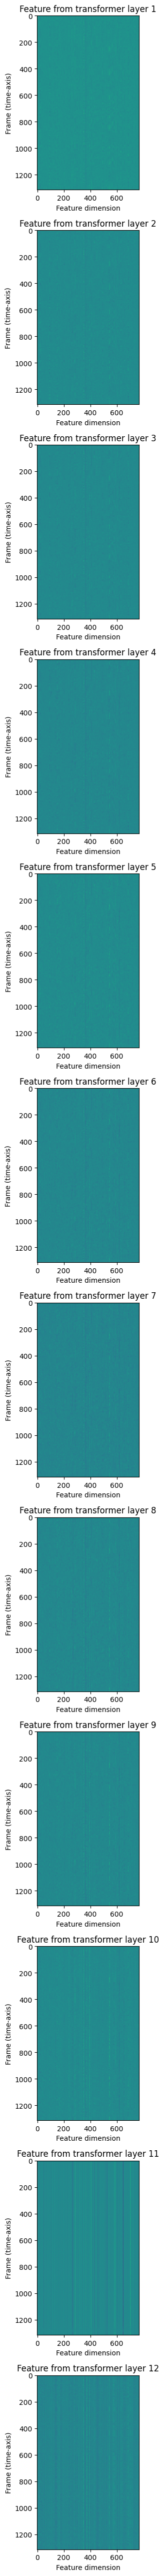

In [25]:
# visualize the features

import matplotlib.pyplot as plt
fig, ax = plt.subplots(len(features), 1, figsize=(16, 4.3 * len(features)))
for i, feats in enumerate(features):
    ax[i].imshow(feats[0].cpu())
    ax[i].set_title(f"Feature from transformer layer {i+1}")
    ax[i].set_xlabel("Feature dimension")
    ax[i].set_ylabel("Frame (time-axis)")
plt.tight_layout()
plt.show()


In [26]:
# feature classification

with torch.inference_mode():
    emission, _ = model(waveform)


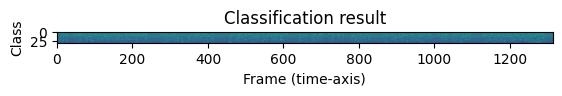

Class labels: ('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


In [27]:
# visualize classification

plt.imshow(emission[0].cpu().T)
plt.title("Classification result")
plt.xlabel("Frame (time-axis)")
plt.ylabel("Class")
plt.show()
print("Class labels:", bundle.get_labels())


In [28]:
# greddey decoding algorithm definition

class GreedyCTCDecoder(torch.nn.Module):
    def __init__(self, labels, blank=0):
        super().__init__()
        self.labels = labels
        self.blank = blank

    def forward(self, emission: torch.Tensor) -> str:
        """Given a sequence emission over labels, get the best path string
        Args:
          emission (Tensor): Logit tensors. Shape `[num_seq, num_label]`.

        Returns:
          str: The resulting transcript
        """
        indices = torch.argmax(emission, dim=-1)  # [num_seq,]
        indices = torch.unique_consecutive(indices, dim=-1)
        indices = [i for i in indices if i != self.blank]
        return "".join([self.labels[i] for i in indices])


In [29]:
# generate the transcript using the above defined decoder

decoder = GreedyCTCDecoder(labels=bundle.get_labels())
transcript = decoder(emission[0])


In [30]:
# check the result

print(transcript)
IPython.display.Audio(SPEECH_FILE)


HIGH|THERE|THIS|IS|A|SAMPLE|VOICE|RECORDING|CREATED|FOR|SPEECH|SYNTHESIS|TESTING|THE|QUICK|BROWN|FOX|JUMPS|OVER|THE|LAZY|DOG|JUST|A|FUN|WAY|TO|INCLUDE|EVERY|LETTER|OF|THE|ALPHABET|NUMBERS|LIKE|ONE|TWO|THREE|ARE|SPOKEN|CLEARLY|LET'S|SEE|HOW|WELL|THIS|VOICE|CAPTURES|TONE|TIMING|AND|NATURAL|RHYTHM|THIS|AUDIO|IS|PROVIDED|BY|SAMPLE|FILES|DAK|KOM|


In [13]:
# using openAI whisper-base model to perform transcription

from transformers import WhisperProcessor, WhisperForConditionalGeneration

# Load Whisper model and processor
processor = WhisperProcessor.from_pretrained("openai/whisper-base")
model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-base")

# Whisper expects 16 kHz mono audio
waveform = torchaudio.functional.resample(waveform, orig_freq=sample_rate, new_freq=16000)
waveform = waveform.mean(dim=0, keepdim=True)  # convert to mono
sample_rate = 16000

# Prepare inputs for the model
inputs = processor(waveform.squeeze().numpy(), sampling_rate=sample_rate, return_tensors="pt")

# Generate transcription ids
with torch.no_grad():
    predicted_ids = model.generate(inputs["input_features"])

# Decode into text
transcription = processor.batch_decode(predicted_ids, skip_special_tokens=True)[0]
print("Transcription:", transcription)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Transcription:  Hi there, this is a sample voice recording created for speech synthesis testing. The quid brown fox jumps over the lazy dog. Just a fun way to include every letter of the alphabet. Numbers like 1, 2, 3 are spoken clearly. Let's see how well this voice captures tone, timing, and natural rhythm. This audio is provided by samplefiles.com.
